In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Tue May  2 21:46:15 2017

@author: zhouyi
"""

import json
import os

import numpy as np
import pandas as pd


# Change this to wherever you keep the data
STEAM_DIR = '/Users/zhouyi/Documents/GraduatePJ/steam_data'

# The dataset can be obtained here:
# https://www.kaggle.com/tamber/steam-video-games
STEAM_file= os.path.join(STEAM_DIR,'steam-200k.csv')

st = pd.read_csv(STEAM_file, header=None, names=['user_id', 'game_name', 'behavior','value','other'])
st=st[st['behavior'].isin(['purchase'])]
st=st[['user_id','game_name','value']]

In [2]:
user_count=st[['user_id','value']].groupby('user_id',as_index=False).size()
game_count=st[['game_name','value']].groupby('game_name',as_index=False).size()

MIN_USERCOUNT=20
MIN_GAMECOUNT=20

#Filter, only keep the triplets for users who purchased at least MIN_USERCOUNT games
#and the games which are played by at least MIN_GAMECOUNT users
st=st[st['user_id'].isin(user_count.index[user_count>=MIN_USERCOUNT])]
st=st[st['game_name'].isin(game_count.index[game_count>=MIN_GAMECOUNT])]
user_count=st[['user_id','value']].groupby('user_id',as_index=False).size()
game_count=st[['game_name','value']].groupby('game_name',as_index=False).size()

sparsity_level = float(st.shape[0]) / (user_count.shape[0] * game_count.shape[0])
print "After filtering, there are %d triplets from %d users and %d games (sparsity level %.3f%%)" % (st.shape[0], 
                                                                                                      user_count.shape[0], 
                                                                                                      game_count.shape[0], 
                                                                                                     sparsity_level * 100)


After filtering, there are 75860 triplets from 1269 users and 1197 games (sparsity level 4.994%)


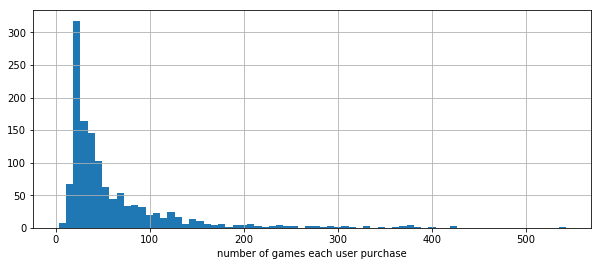

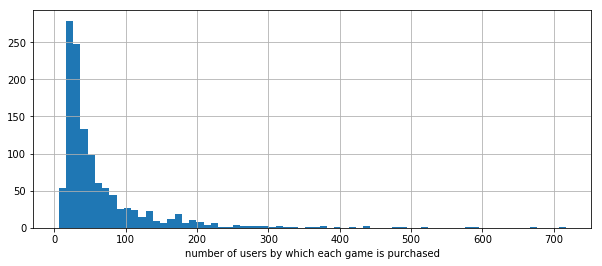

In [3]:
#visualize user_count and game_count
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
user_count.hist(bins=70)
plt.xlabel('number of games each user purchase')


plt.figure(figsize=(10, 4))
game_count.hist(bins=70)
plt.xlabel('number of users by which each game is purchased')
plt.show()

In [4]:
#Top 10 popular games are
print "--------------------------------"
print "TOP 10 POPULAR GAMES FROM STEAM"
print "--------------------------------"
game_in_order=game_count.order(ascending=False).index
for i in range(10):
    print "%d ,%s" %(i+1,game_in_order[i])
print "--------------------------------"

--------------------------------
TOP 10 POPULAR GAMES FROM STEAM
--------------------------------
1 ,Team Fortress 2
2 ,Counter-Strike Global Offensive
3 ,Dota 2
4 ,Left 4 Dead 2
5 ,Unturned
6 ,The Elder Scrolls V Skyrim
7 ,Garry's Mod
8 ,Counter-Strike Source
9 ,Portal 2
10 ,Half-Life 2 Lost Coast
--------------------------------


/Users/zhouyi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: order is deprecated, use sort_values(...)


In [5]:
#Transform
unique_user_id = user_count.index
unique_game_name = game_count.index

game2id = dict((game_name, i) for (i, game_name) in enumerate(unique_game_name))
user2id = dict((user_id, i) for (i, user_id) in enumerate(unique_user_id))

with open(os.path.join(STEAM_DIR, 'unique_user_id.txt'), 'w') as f:
    for uid in unique_user_id:
        f.write('%s\n' % uid)

with open(os.path.join(STEAM_DIR, 'unique_game_name.txt'), 'w') as f:
    for gname in unique_game_name:
        f.write('%s\n' % gname)

In [6]:
#Generate train/test/vad sets

##Pick out 20% of the rating for heldout test
np.random.seed(95616)
n_ratings = st.shape[0]
test = np.random.choice(n_ratings, size=int(0.20 * n_ratings), replace=False)

test_idx = np.zeros(n_ratings, dtype=bool)
test_idx[test] = True

test_st = st[test_idx]
train_st = st[~test_idx]

##Make sure there is no empty row or column in the training data
print "There are total of %d unique users in the training set and %d unique users in the entire dataset" % \
(len(pd.unique(train_st['user_id'])), len(pd.unique(st['user_id'])))
print "There are total of %d unique items in the training set and %d unique items in the entire dataset" % \
(len(pd.unique(train_st['game_name'])), len(pd.unique(st['game_name'])))

##Pick out 10% of the training rating as validation set
np.random.seed(13579)
n_ratings = train_st.shape[0]
vad = np.random.choice(n_ratings, size=int(0.10 * n_ratings), replace=False)
    
vad_idx = np.zeros(n_ratings, dtype=bool)
vad_idx[vad] = True

vad_st = train_st[vad_idx]
train_st = train_st[~vad_idx]

##Again make sure there is no empty row or column in the training data
print "There are total of %d unique users in the training set and %d unique users in the entire dataset" % \
(len(pd.unique(train_st['user_id'])), len(pd.unique(st['user_id'])))
print "There are total of %d unique items in the training set and %d unique items in the entire dataset" % \
(len(pd.unique(train_st['game_name'])), len(pd.unique(st['game_name'])))

There are total of 1269 unique users in the training set and 1269 unique users in the entire dataset
There are total of 1197 unique items in the training set and 1197 unique items in the entire dataset
There are total of 1269 unique users in the training set and 1269 unique users in the entire dataset
There are total of 1197 unique items in the training set and 1197 unique items in the entire dataset


In [7]:
#Numerize the data into (user_index, item_index, count) format

def numerize(st):
    user_id = map(lambda x: user2id[x], st['user_id'])
    game_id = map(lambda x: game2id[x], st['game_name'])
    st['user_id'] = user_id
    st['game_name'] = game_id
    return st

train_st = numerize(train_st)
train_st.to_csv(os.path.join(STEAM_DIR, 'train.num.sub.csv'), index=False)
test_st = numerize(test_st)
test_st.to_csv(os.path.join(STEAM_DIR, 'test.num.sub.csv'), index=False)
vad_st = numerize(vad_st)
vad_st.to_csv(os.path.join(STEAM_DIR, 'vad.num.sub.csv'), index=False)

/Users/zhouyi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/zhouyi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
